In [4]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [5]:
s = []
prefix = "HH_client_BITP_"
num_files = 4
for i in range(num_files):
    if i == 0:
        s.append(open("test-client-id-bitp-all-stats.txt", "r").readlines())
    else:
        s.append(open("test-client-id-bitp-all-stats-0%d.txt" % i, "r").readlines())

In [6]:
raw_pr = []
raw_mem = []
raw_time = []
for i in range(num_files):
    ln = 0
    query_type = ""
    for line in s[i]:
        if line.startswith("Stats request at line"):
            ln = int(re.search("\d+", line).group())
        if line.find(" timers") != -1:
            query_type = line.strip().split(" ")[0]
        if line.find(" ms = ") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                sketch = [sketch[0], ''.join(sketch[1:])]
                raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
        if line.find("prec") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                sketch = [sketch[0], ''.join(sketch[1:])]
                pr_info = t[1].split(",")
                try:
                    pr_info = list(map(lambda x: eval(x.split('=')[1].strip()), pr_info))
                except ZeroDivisionError:
                    continue
                raw_pr.append(sketch + ["Precision", pr_info[0]])
                raw_pr.append(sketch + ["Recall", pr_info[1]])
        if line.find("MB") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
                raw_mem.append(t)

In [7]:
mem_df = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage"])
mem_df

,Sketch,Param,Stream Size,Memory Usage
0,PCM_HH,logU23e0.001d0.001D2000,0,1051342932
1,TMG_BITP,e0.000200,0,3676730552
2,TMG_BITP,e0.000100,0,5632573720
3,TMG_BITP,e0.000050,0,8389647472
4,TMG_BITP,e0.000040,0,9587477152
...,...,...,...,...
2112,SAMPLING_BITP,ss100000use_new_impl2_max,1352804200,140805056
2113,SAMPLING_BITP,ss1000000use_new_impl2,1352804200,590098560
2114,SAMPLING_BITP,ss1000000use_new_impl2_max,1352804200,1344005056
2115,SAMPLING_BITP,ss3000000use_new_impl2,1352804200,781134208


In [8]:
time_df = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Value"])
time_df_processed = pd.merge(time_df, mem_df, on = ["Sketch", "Param", "Stream Size"]).drop_duplicates()
update_time_df = time_df_processed[time_df_processed["Type"] == "Update"]
update_time_df

,Sketch,Param,Stream Size,Type,Value,Memory Usage
0,PCM_HH,logU23e0.001d0.001D2000,0,Update,23155357,1051342932
2,TMG_BITP,e0.000200,0,Update,2926585,3676730552
4,TMG_BITP,e0.000100,0,Update,2726224,5632573720
6,TMG_BITP,e0.000050,0,Update,2552065,8389647472
8,TMG_BITP,e0.000040,0,Update,2460978,9587477152
...,...,...,...,...,...,...
3909,SAMPLING_BITP,ss20000use_new_impl2,1352804200,Update,1376800,23376608
3916,SAMPLING_BITP,ss50000use_new_impl2,1352804200,Update,1441286,35265280
3917,SAMPLING_BITP,ss50000use_new_impl2,1352804200,Update,1441286,35265504
3924,SAMPLING_BITP,ss100000use_new_impl2,1352804200,Update,1507394,84761184


In [9]:
pr_df = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Metric", "Value"])
pr_df

,Sketch,Param,Metric,Value
0,PCM_HH,logU23e0.001d0.001D2000,Precision,0.000080
1,PCM_HH,logU23e0.001d0.001D2000,Recall,1.000000
2,TMG_BITP,e0.000200,Precision,0.317269
3,TMG_BITP,e0.000200,Recall,1.000000
4,TMG_BITP,e0.000100,Precision,0.634538
...,...,...,...,...
317,SAMPLING_BITP,ss100000use_new_impl2,Recall,0.873418
318,SAMPLING_BITP,ss1000000use_new_impl2,Precision,0.955414
319,SAMPLING_BITP,ss1000000use_new_impl2,Recall,0.949367
320,SAMPLING_BITP,ss3000000use_new_impl2,Precision,0.981013


In [11]:
last_mem_df = mem_df.groupby(["Sketch", "Param"]).agg({"Memory Usage": "max"})
last_mem_df

Memory Usage
Sketch        Param                                   
PCM_HH        logU22e0.001d0.001D2000       1044703600
              logU22e0.001d0.01D1e+07         46705568
              logU22e0.001d0.01D2000         746891648
              logU22e0.002d0.01D2000         656750344
              logU23e0.001d0.001D2000       1051342932
              logU23e0.001d0.01D2000         751634044
              logU23e0.002d0.01D2000         660432720
SAMPLING_BITP ss1000000use_new_impl2        1325688128
              ss1000000use_new_impl2_max    1344005056
              ss100000use_new_impl2          132088800
              ss100000use_new_impl2_max      140805056
              ss10000use_new_impl2            13414464
              ss10000use_new_impl2_max        14085056
              ss20000use_new_impl2            26159552
              ss20000use_new_impl2_max        28165056
              ss3000000use_new_impl2        4024481120
              ss3000000use_new_impl2_max    4032005056
              ss50000use_new_impl2            67170592
              ss50000use_new_impl2_max        70405056
TMG_BITP      e0.000040                     9587477152
              e0.000050                     8389647472
              e0.000100                     5632573720
              e0.000200                     3676730552
              e0.000600                     3460741664

In [12]:
pr_df_processed = pd.DataFrame(pd.merge(pr_df, last_mem_df, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage", "Metric"]).mean().to_records())
pr_df_processed

,Sketch,Param,Memory Usage,Metric,Value
0,PCM_HH,logU22e0.001d0.001D2000,1044703600,Precision,0.107759
1,PCM_HH,logU22e0.001d0.001D2000,1044703600,Recall,0.973684
2,PCM_HH,logU22e0.001d0.01D1e+07,46705568,Precision,0.126557
3,PCM_HH,logU22e0.001d0.01D1e+07,46705568,Recall,1.000000
4,PCM_HH,logU22e0.001d0.01D2000,746891648,Precision,0.109050
5,PCM_HH,logU22e0.001d0.01D2000,746891648,Recall,0.976504
6,PCM_HH,logU22e0.002d0.01D2000,656750344,Precision,0.088820
7,PCM_HH,logU22e0.002d0.01D2000,656750344,Recall,0.977444
8,PCM_HH,logU23e0.001d0.001D2000,1051342932,Precision,0.107759
9,PCM_HH,logU23e0.001d0.001D2000,1051342932,Recall,0.973684


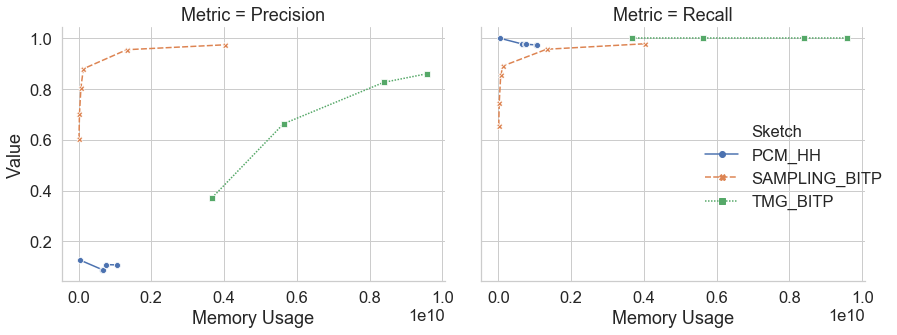

In [13]:
g = sns.relplot(x="Memory Usage", y="Value", hue="Sketch", style = "Sketch", col = "Metric", kind = "line",  markers=True,data=pr_df_processed)
plt.tight_layout()
plt.savefig(prefix + 'pr.pdf')

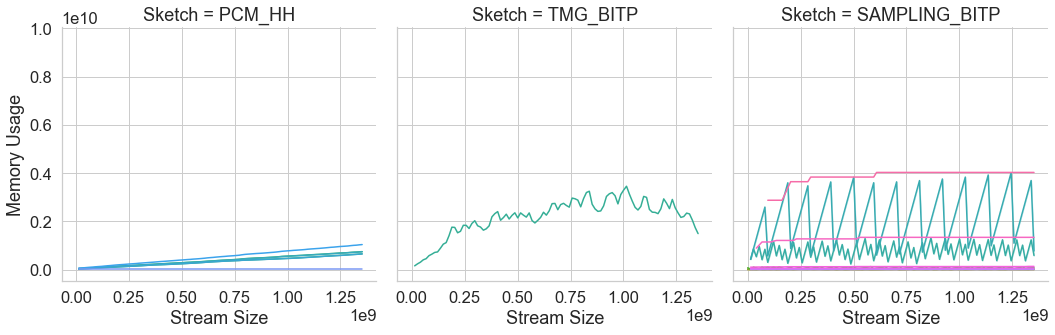

In [14]:
g = sns.relplot(x="Stream Size", y="Memory Usage", hue="Param", data=mem_df, dashes = False, col="Sketch",
                kind="line", legend=False)
plt.tight_layout()
plt.savefig(prefix + 'mem.pdf')

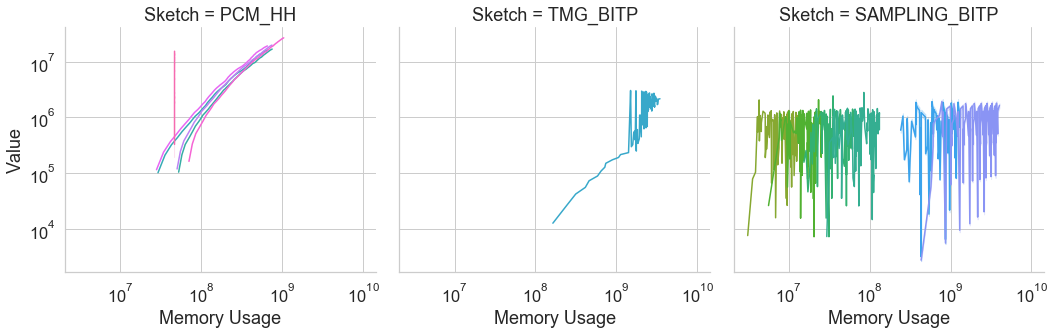

In [15]:
g = sns.relplot(x="Memory Usage", y="Value", hue="Param", style = "Param", col = "Sketch", kind = "line",  dashes = False, data=update_time_df, legend = False)
g.set(xscale = "log", yscale="log")
plt.tight_layout()
plt.savefig(prefix + 'time.pdf')